In [1]:
from putils import get_observation, plot_geometry, plot_matrix
from dautils import sample_winddirection, sample_windspeed, validate_geom, adjusted_state_EnKF_farsite, geom_to_state, align_states
from futils import forward_pass_farsite, generate_landscape

from shapely import Polygon
from shapely.ops import unary_union

import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

import pickle
import datetime
import os
import contextily as ctx

import geopandas as gpd
import pandas as pd

from xml.dom import minidom

def save_svg(geom, filepath):
    x,y = (-2084217.1484733422, 1503560.461310427)
    width = 500
    
    xshift = 5000
    yshift = 5000

    x += xshift
    y+= yshift
    reference = Polygon([(x-width, y), (x, y), (x,y-width), (x-width, y-width)])
    
    with open(filepath, 'w') as f:
        
        doc = minidom.parseString(unary_union([geom, reference])._repr_svg_())  # parseString also exists
        doc.getElementsByTagName('svg')[0].setAttribute('viewBox', '-2090656.1702135054 1500502.5853300707 11878.98411478498 8497.838354978012')
        print(doc.toxml(), end='', file=f)

In [2]:
description = 'Maria2019'
tfin = 10

wslst = [11, 18, 18, 25, 17, 22, 15, 12, 14, 14, 14]
wdlst = [37, 48, 48, 44, 16, 29, 19, 24, 22, 21, 20]

n_vertex = 20
n_samples = 250
wssigma = 5
wdsigma = 90
vsize=1  # Observation uncertainty
wsize=100   # Model uncertainty
rng = np.random.Generator(np.random.PCG64(1234))

n_states = 2*n_vertex
n_output = n_states    
dist_res = 150
perim_res = 150

observations = []
timestamps = []
sampled_wslst = []
sampled_wdlst = []

for tix in tqdm(range(tfin)):
    obs, ts = get_observation(description, tix)
    observations.append(validate_geom(obs))
    timestamps.append(ts)
    sampled_wslst.append([])
    sampled_wdlst.append([])
    for s in range(n_samples):
        sampled_wslst[-1].append(sample_windspeed(wslst[tix],wssigma,rng))
        sampled_wdlst[-1].append(sample_winddirection(wdlst[tix], wdsigma, rng))
        
lcppath = generate_landscape(observations[-1], description=description)

align_state = geom_to_state(observations[0])

100%|██████████| 10/10 [00:01<00:00,  6.78it/s]


2019-10-31 19:37:11
0 days 00:00:00
0 days 00:21:11
0 days 00:54:22
0 days 01:19:33
0 days 01:45:44
0 days 03:53:49
0 days 04:10:49
0 days 04:51:49
0 days 05:16:49
0 days 05:34:49


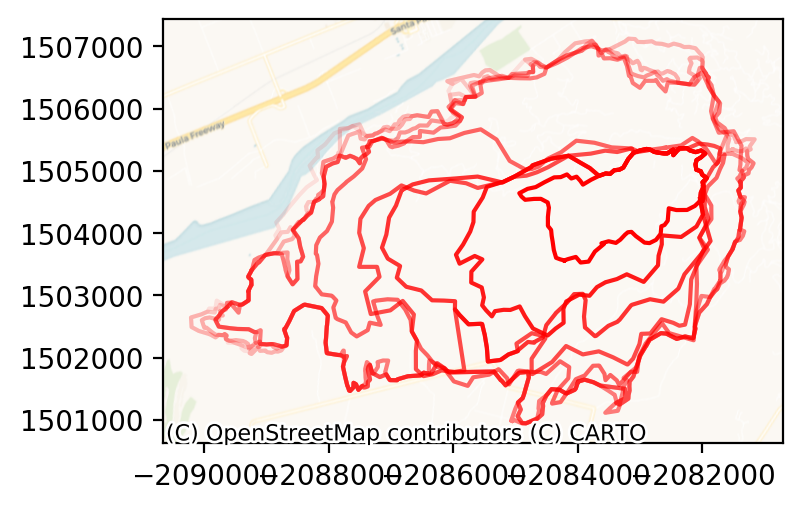

In [3]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

print(timestamps[0])
for i, (geom, dt) in enumerate(zip(observations, timestamps)):
    plot_geometry(validate_geom(geom), ax=ax, color='red', alpha=1-i/len(observations))
    print(dt - timestamps[0])

ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Voyager, crs='EPSG:5070')

## Generate ignition

In [4]:
# Maria ignition
ignition_timepoint = timestamps[0].replace(hour=19, minute=0)
x,y = (-2084217.1484733422, 1503560.461310427)
width = 200
xshift = 2000
yshift = 1500

x += xshift
y+= yshift
ignition = Polygon([(x-width, y), (x, y), (x,y-width), (x-width, y-width)])

## Model output at tp0

In [5]:
poly = ignition
filepath = f'/home/tcaglar/farsite-devAPI/data/UI_test/tp0/Maria_tp0_model00.svg'
save_svg(poly, filepath)
model_timepoints = [ignition_timepoint]
model_outputs_tp0 = [ignition]
Xtp0_lst = [1e3*np.eye(n_states)]
for i in tqdm(range(6)):
    dt = datetime.timedelta(seconds=30*60)
    model_timepoints.append(ignition_timepoint + (i+1)*dt)
    poly = forward_pass_farsite(poly, params={'windspeed': wslst[0], 'winddirection': wdlst[0], 'dt': dt}, description='Maria2019', lcppath=lcppath)
    model_outputs_tp0.append(poly)
    Xtp0_lst.append(1e3*np.eye(n_states))
    filepath = f'/home/tcaglar/farsite-devAPI/data/UI_test/tp0/Maria_tp0_model0{i+1}.svg'
    save_svg(poly, filepath)

100%|██████████| 6/6 [00:01<00:00,  5.08it/s]


## Measurement arrived at tp1

In [6]:
# Save observation at tp1
tix = 1  # Calculating for tp{tix}
filepath = f'/home/tcaglar/farsite-devAPI/data/UI_test/tp{tix}/Maria_tp{tix}_meas{tix}.svg'
observation = observations[tix-1]
timepoint = timestamps[tix-1]
save_svg(observation, filepath)

# Save the model outputs up to the observation timepoint
model_outputs_tp1 = []
Xtp1_lst = []
for i, tp in enumerate(model_timepoints):
    if tp > timepoint:
        break
    model_outputs_tp1.append(model_outputs_tp0[i])
    Xtp1_lst.append(Xtp0_lst[i])  # Initial covariance matrix
    
# Calculate initial_state for model adjustments
# if dt < 10 minutes, use the previous timestamp (30 minutes more)
dt = timepoint - model_timepoints[i-1]
geom = model_outputs_tp0[i-1]  # Starting polygon for calculating the initial_state
if dt.seconds/60 < 10:
    dt = timepoint - model_timepoints[i-2]
    geom = model_outputs_tp0[i-2]

params = {'windspeed': wslst[tix-1], 'winddirection': wdlst[tix-1], 'dt': dt}
initial_geom = forward_pass_farsite(geom, params, lcppath, 
                                    description='Maria2019_UI', 
                                    dist_res=dist_res,
                                    perim_res=perim_res)

# Calculate adjusted geom for each 30-minute forward pass

# Generate state from geometry
initial_state = geom_to_state(initial_geom)
observation_state = geom_to_state(observation)
# vertex alignment
_, initial_state = align_states([align_state, initial_state], vertex_count=n_vertex)
_, observation_state = align_states([align_state, observation_state], vertex_count=n_vertex)

for i, tp in enumerate(model_timepoints[i:]):
    print(f'Calculating timepoint={tp}')
    # Check if first dt > 10 minutes
    dt = tp - timepoint # From the initial_state timepoint to the next model output
    if dt.seconds/60 < 10: # cannot calculate less than 10-minutes
        model_outputs_tp1.append(model_outputs_tp0[i])   # append output from previous step
        Xtp1_lst.append(Xtp0_lst[i])  # Initial covariance matrix

        continue

    adjusted_state, Xp, zkphat_ensemble, xkhat_ensemble, ykhat_ensemble, xkphat_ensemble = adjusted_state_EnKF_farsite(
        initial_state, observation_state, Xtp0_lst[i], n_states, n_output, n_vertex, n_samples, 
        rng, sampled_wslst[tix-1], sampled_wdlst[tix-1], dt, vsize, wsize, 
        description, dist_res, perim_res)
    
    adjusted_geom = Polygon(zip(adjusted_state[::2], adjusted_state[1::2]))
    model_outputs_tp1.append(adjusted_geom)
    Xtp1_lst.append(Xp)  # Initial covariance matrix

    
for i, poly in enumerate(model_outputs_tp1):
    filepath = f'/home/tcaglar/farsite-devAPI/data/UI_test/tp1/Maria_tp1_model0{i+1}.svg'
    save_svg(poly, filepath)

Calculating timepoint=2019-10-31 20:00:11


100%|██████████| 250/250 [00:24<00:00, 10.21it/s]


Calculating timepoint=2019-10-31 20:30:11


100%|██████████| 250/250 [00:49<00:00,  5.03it/s]


Calculating timepoint=2019-10-31 21:00:11


100%|██████████| 250/250 [01:17<00:00,  3.23it/s]


Calculating timepoint=2019-10-31 21:30:11


100%|██████████| 250/250 [01:50<00:00,  2.26it/s]


Calculating timepoint=2019-10-31 22:00:11


100%|██████████| 250/250 [02:28<00:00,  1.68it/s]


## Measurement arrived at tp2

In [7]:
# Save observation at tp2
tix = 2  # Calculating for tp{tix}
filepath = f'/home/tcaglar/farsite-devAPI/data/UI_test/tp{tix}/Maria_tp{tix}_meas{tix}.svg'

observation = observations[tix-1]
timepoint = timestamps[tix-1]
save_svg(observation, filepath)

# Save the model outputs up to the observation timepoint
model_outputs_tp2 = []
Xtp2_lst = []
for i, tp in enumerate(model_timepoints):
    if tp > timepoint:
        break
    model_outputs_tp2.append(model_outputs_tp1[i])
    Xtp2_lst.append(Xtp1_lst[i])
    
# Calculate initial_state for model adjustments
# if dt < 10 minutes, use the previous timestamp (30 minutes more)
dt = timepoint - model_timepoints[i-1]
geom = model_outputs_tp1[i-1]  # Starting polygon for calculating the initial_state
if dt.seconds/60 < 10:
    dt = timepoint - model_timepoints[i-2]
    geom = model_outputs_tp1[i-2]

params = {'windspeed': wslst[tix-1], 'winddirection': wdlst[tix-1], 'dt': dt}
initial_geom = forward_pass_farsite(geom, params, lcppath, 
                                    description='Maria2019_UI', 
                                    dist_res=dist_res,
                                    perim_res=perim_res)

# Calculate adjusted geom for each 30-minute forward pass
# X = 1e3*np.eye(n_states)  # Initial covariance matrix
# Generate state from geometry
initial_state = geom_to_state(initial_geom)
observation_state = geom_to_state(observation)
# vertex alignment
_, initial_state = align_states([align_state, initial_state], vertex_count=n_vertex)
_, observation_state = align_states([align_state, observation_state], vertex_count=n_vertex)

for j, tp in enumerate(model_timepoints[i:]):
    print(f'Calculating timepoint={tp}')
    # Check if first dt > 10 minutes
    dt = tp - timepoint # From the initial_state timepoint to the next model output
    if dt.seconds/60 < 10: # cannot calculate less than 10-minutes
        model_outputs_tp2.append(model_outputs_tp1[j])   # append output from previous step
        Xtp2_lst.append(Xtp1_lst[j])
        continue

    adjusted_state, Xp, zkphat_ensemble, xkhat_ensemble, ykhat_ensemble, xkphat_ensemble = adjusted_state_EnKF_farsite(
        initial_state, observation_state, Xtp1_lst[j], n_states, n_output, n_vertex, n_samples, 
        rng, sampled_wslst[tix-1], sampled_wdlst[tix-1], dt, vsize, wsize, 
        description, dist_res, perim_res)
    
    adjusted_geom = Polygon(zip(adjusted_state[::2], adjusted_state[1::2]))
    model_outputs_tp2.append(adjusted_geom)
    Xtp2_lst.append(Xp)
    
for i, poly in enumerate(model_outputs_tp2):
    filepath = f'/home/tcaglar/farsite-devAPI/data/UI_test/tp{tix}/Maria_tp{tix}_model0{i+1}.svg'
    save_svg(poly, filepath)

Calculating timepoint=2019-10-31 20:00:11
Calculating timepoint=2019-10-31 20:30:11


100%|██████████| 250/250 [00:24<00:00, 10.23it/s]


Calculating timepoint=2019-10-31 21:00:11


100%|██████████| 250/250 [00:52<00:00,  4.78it/s]


Calculating timepoint=2019-10-31 21:30:11


100%|██████████| 250/250 [01:27<00:00,  2.85it/s]


Calculating timepoint=2019-10-31 22:00:11


100%|██████████| 250/250 [02:12<00:00,  1.88it/s]


## Measurement arrived at tp3

In [8]:
# Save observation at tp3
tix = 3  # Calculating for tp{tix}
filepath = f'/home/tcaglar/farsite-devAPI/data/UI_test/tp{tix}/Maria_tp{tix}_meas{tix}.svg'

observation = observations[tix-1]
timepoint = timestamps[tix-1]
save_svg(observation, filepath)

# Save the model outputs up to the observation timepoint
model_outputs_tp3 = []
Xtp3_lst = []
for i, tp in enumerate(model_timepoints):
    if tp > timepoint:
        break
    model_outputs_tp3.append(model_outputs_tp2[i])
    Xtp3_lst.append(Xtp2_lst[i])
    
# Calculate initial_state for model adjustments
# if dt < 10 minutes, use the previous timestamp (30 minutes more)
dt = timepoint - model_timepoints[i-1]
geom = model_outputs_tp2[i-1]  # Starting polygon for calculating the initial_state
if dt.seconds/60 < 10:
    dt = timepoint - model_timepoints[i-2]
    geom = model_outputs_tp2[i-2]

params = {'windspeed': wslst[tix-1], 'winddirection': wdlst[tix-1], 'dt': dt}
initial_geom = forward_pass_farsite(geom, params, lcppath, 
                                    description='Maria2019_UI', 
                                    dist_res=dist_res,
                                    perim_res=perim_res)

# Calculate adjusted geom for each 30-minute forward pass
# X = 1e3*np.eye(n_states)  # Initial covariance matrix
# Generate state from geometry
initial_state = geom_to_state(initial_geom)
observation_state = geom_to_state(observation)
# vertex alignment
_, initial_state = align_states([align_state, initial_state], vertex_count=n_vertex)
_, observation_state = align_states([align_state, observation_state], vertex_count=n_vertex)

for j, tp in enumerate(model_timepoints[i:]):
    print(f'Calculating timepoint={tp}')
    # Check if first dt > 10 minutes
    dt = tp - timepoint # From the initial_state timepoint to the next model output
    if dt.seconds/60 < 10: # cannot calculate less than 10-minutes
        model_outputs_tp3.append(model_outputs_tp2[j])   # append output from previous step
        Xtp3_lst.append(Xtp2_lst[j])
        continue

    adjusted_state, Xp, zkphat_ensemble, xkhat_ensemble, ykhat_ensemble, xkphat_ensemble = adjusted_state_EnKF_farsite(
        initial_state, observation_state, Xtp2_lst[j], n_states, n_output, n_vertex, n_samples, 
        rng, sampled_wslst[tix-1], sampled_wdlst[tix-1], dt, vsize, wsize, 
        description, dist_res, perim_res)
    
    adjusted_geom = Polygon(zip(adjusted_state[::2], adjusted_state[1::2]))
    model_outputs_tp3.append(adjusted_geom)
    Xtp3_lst.append(Xp)
    
for i, poly in enumerate(model_outputs_tp3):
    filepath = f'/home/tcaglar/farsite-devAPI/data/UI_test/tp{tix}/Maria_tp{tix}_model0{i+1}.svg'
    save_svg(poly, filepath)

Calculating timepoint=2019-10-31 21:00:11


100%|██████████| 250/250 [00:33<00:00,  7.39it/s]


Calculating timepoint=2019-10-31 21:30:11


100%|██████████| 250/250 [01:19<00:00,  3.16it/s]


Calculating timepoint=2019-10-31 22:00:11


100%|██████████| 250/250 [02:24<00:00,  1.73it/s]


## Measurement at tp4

In [9]:
# Save observation at tp4
tix = 4  # Calculating for tp{tix}
filepath = f'/home/tcaglar/farsite-devAPI/data/UI_test/tp{tix}/Maria_tp{tix}_meas{tix}.svg'

observation = observations[tix-1]
timepoint = timestamps[tix-1]
save_svg(observation, filepath)

# Save the model outputs up to the observation timepoint
model_outputs_tp4 = []
Xtp4_lst = []
for i, tp in enumerate(model_timepoints):
    if tp > timepoint:
        break
    model_outputs_tp4.append(model_outputs_tp3[i])
    Xtp4_lst.append(Xtp3_lst[i])
    
# Calculate initial_state for model adjustments
# if dt < 10 minutes, use the previous timestamp (30 minutes more)
dt = timepoint - model_timepoints[i-1]
geom = model_outputs_tp3[i-1]  # Starting polygon for calculating the initial_state
if dt.seconds/60 < 10:
    dt = timepoint - model_timepoints[i-2]
    geom = model_outputs_tp3[i-2]

params = {'windspeed': wslst[tix-1], 'winddirection': wdlst[tix-1], 'dt': dt}
initial_geom = forward_pass_farsite(geom, params, lcppath, 
                                    description='Maria2019_UI', 
                                    dist_res=dist_res,
                                    perim_res=perim_res)

# Calculate adjusted geom for each 30-minute forward pass
# X = 1e3*np.eye(n_states)  # Initial covariance matrix
# Generate state from geometry
initial_state = geom_to_state(initial_geom)
observation_state = geom_to_state(observation)
# vertex alignment
_, initial_state = align_states([align_state, initial_state], vertex_count=n_vertex)
_, observation_state = align_states([align_state, observation_state], vertex_count=n_vertex)

for j, tp in enumerate(model_timepoints[i:]):
    print(f'Calculating timepoint={tp}')
    # Check if first dt > 10 minutes
    dt = tp - timepoint # From the initial_state timepoint to the next model output
    if dt.seconds/60 < 10: # cannot calculate less than 10-minutes
        model_outputs_tp4.append(model_outputs_tp3[j])   # append output from previous step
        Xtp4_lst.append(Xtp3_lst[j])
        continue

    adjusted_state, Xp, zkphat_ensemble, xkhat_ensemble, ykhat_ensemble, xkphat_ensemble = adjusted_state_EnKF_farsite(
        initial_state, observation_state, Xtp3_lst[j], n_states, n_output, n_vertex, n_samples, 
        rng, sampled_wslst[tix-1], sampled_wdlst[tix-1], dt, vsize, wsize, 
        description, dist_res, perim_res)
    
    adjusted_geom = Polygon(zip(adjusted_state[::2], adjusted_state[1::2]))
    model_outputs_tp4.append(adjusted_geom)
    Xtp4_lst.append(Xp)
    
for i, poly in enumerate(model_outputs_tp4):
    filepath = f'/home/tcaglar/farsite-devAPI/data/UI_test/tp{tix}/Maria_tp{tix}_model0{i+1}.svg'
    save_svg(poly, filepath)

Calculating timepoint=2019-10-31 21:00:11
Calculating timepoint=2019-10-31 21:30:11


100%|██████████| 250/250 [01:50<00:00,  2.25it/s]


Calculating timepoint=2019-10-31 22:00:11


100%|██████████| 250/250 [08:00<00:00,  1.92s/it]


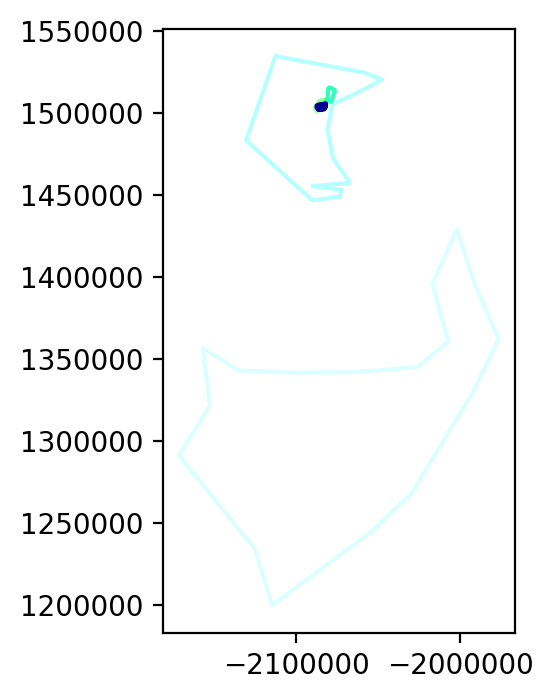

In [13]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

for i, (geom, geom1, geom2, geom3, geom4) in enumerate(zip(model_outputs_tp0, model_outputs_tp1, model_outputs_tp2, model_outputs_tp3, model_outputs_tp4)):
    plot_geometry(geom, ax=ax, color=(1,0,0,1-i/7))
#     plot_geometry(geom1, ax=ax, color=(0,0,1,1-i/7))
    plot_geometry(geom2, ax=ax, color=(0,1,0,1-i/7))
#     plot_geometry(geom3, ax=ax, color=(1,1,0,1-i/7))
    plot_geometry(geom4, ax=ax, color=(0,1,1,1-i/7))
    
plot_geometry(observations[0], ax=ax, color=(0,0,1))
plot_geometry(observations[1], ax=ax, color=(0,0,6/7))
plot_geometry(observations[2], ax=ax, color=(0,0,5/7))
plot_geometry(observations[3], ax=ax, color=(0,0,4/7))

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
plot_geometry(model_outputs_tp0[0], ax=ax)
plot_geometry(model_outputs_tp0[1], ax=ax)
plot_geometry(model_outputs_tp0[2], ax=ax)

plot_geometry(initial_geom, ax=ax)
plot_matrix(adjusted_state, ax=ax)
plot_geometry(observation, ax=ax, color='k')
# plot_geometry(model_outputs_tp0[0], ax=ax)

## Adjusted geoms at tp0

In [ ]:
###########################################
#### CALCULATE ADJUSTED MODEL OUTPUT ######
###########################################
# Input of data assimilation
n_states = 2*n_vertex
n_output = n_states
tix = 0
initial_state = geom_to_state(ignition)
observation_state = geom_to_state(observations[tix])

dist_res = 150
perim_res = 150

for i in range(15):
    print(f'Calculating {i}/15...')
    if timestamps[tix] < (model_timepoints[i] + datetime.timedelta(seconds=10*60)):
        X = 1e3*np.eye(n_states)  # Initial covariance matrix
        initial_state, observation_state = align_states([initial_state, observation_state], vertex_count=n_vertex)
        adjusted_state, X, zkphat_ensemble, xkhat_ensemble, ykhat_ensemble, xkphat_ensemble = adjusted_state_EnKF_farsite(
            initial_state, observation_state, X, n_states, n_output, n_vertex, n_samples, 
            rng, sampled_wslst[tix], sampled_wdlst[tix], dt, vsize, wsize, 
            description, dist_res, perim_res)

        adjusted_geom = Polygon(zip(adjusted_state[::2], adjusted_state[1::2]))
    else:
        adjusted_geom = model_outputs_tp0[i]
        
    filepath = f'/home/tcaglar/farsite-devAPI/data/UI_test/tp0/Maria_tp0_model_adjust0{i+1}.svg'
    save_svg(adjusted_geom, filepath)

In [ ]:
timestamps